In [1]:
import warnings

warnings.filterwarnings("ignore")

In [58]:
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import LinearPerSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import FilterFeaturesTransform
from etna.transforms import HolidayTransform
from etna.transforms import LagTransform
from etna.transforms import MeanTransform

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np
import matplotlib.pyplot as plt

## open data, fill all nans

In [3]:
regressor_df = pd.read_csv('train.csv')
regressor_df['timestamp'] = pd.to_datetime(regressor_df['Пеиод__Начало нед'])
regressor_df.drop(columns=['Пеиод__Начало нед'], inplace=True)

In [4]:
replaced_0_df = regressor_df.replace(0, np.nan).replace('0', np.nan).replace(' ', np.nan)
small_df = replaced_0_df.dropna(thresh=100, axis='columns')
regressor_df = small_df[~small_df['1_KPI \nданные понедельно АлфаРМ_Продажи, рубли'].isna()]
small_df.head()

,Пеиод__неделя,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли","1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки",2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,5_выписки врачами_Выписки,6_статистика заболеваемости_Статистика заболеваемости,7_индекс цены_Индекс цены,8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),8_развитие дженериков_Развитие Дженериков \n(кол-во брендов),"11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли",...,"13_Медиа (Конкурент 11)_Диджитал, руб.10",13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, рубли.11","13_Медиа (Конкурент 12)_Диджитал, руб.11","13_Медиа (Конкурент 12)_ТВ Рег, рубли.5",13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12,timestamp
0,1,4.153557e+07,114621.15,0.92107,99698.595433,508956.0,1.54132,NaN,NaN,1057612.5,...,227587.5,5.897845e+06,191.587053,9.8385,1645238.9337096778,3.033352e+06,7.155664e+06,1.183425e+07,9.085528e+06,2018-12-31
1,2,5.122229e+07,141523.20,0.92107,99698.595433,804825.0,1.54132,NaN,NaN,844452.0,...,229446.0,6.844746e+06,142.215997,10.0800,1919445.4226612907,3.728812e+06,8.348274e+06,1.399653e+07,1.059978e+07,2019-01-07
2,3,5.712735e+07,157926.30,0.92107,99698.595433,993384.0,1.54132,NaN,NaN,1235682.0,...,984564.0,7.599864e+06,98.844036,6.1320,1919445.4226612907,1.198575e+06,8.348274e+06,1.146629e+07,1.059978e+07,2019-01-14
3,4,6.304099e+07,173746.65,0.92107,99698.595433,1186542.0,1.54132,NaN,NaN,538272.0,...,897813.0,7.513113e+06,201.975398,15.8550,1919445.4226612907,4.969125e+05,8.348274e+06,1.076463e+07,1.059978e+07,2019-01-21
4,5,6.733689e+07,185551.80,0.92107,99698.595433,1454817.0,1.54132,NaN,NaN,NaN,...,1003590.0,1.059384e+07,105.756137,6.1530,1911792.1603064518,5.961375e+05,8.477038e+06,1.098497e+07,1.289309e+07,2019-01-28


## prepare target df

In [5]:
COLUMNS_TO_PREDICT = [
       '1_KPI \nданные понедельно АлфаРМ_Продажи, рубли',
       '8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция)',
       '6_статистика заболеваемости_Статистика заболеваемости',
       '13_Медиа (Конкурент 12)_ТВ, рубли.11',
       '14_Запросы Wordstat_Запросы Wordstat',
       '5_выписки врачами_Выписки ',
       '2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин',
       'Пеиод__неделя',
       '11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли',
       '13_Медиа (Конкурент 12)_ТВ Рег, рубли.5',
       '13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11',
       '7_индекс цены_Индекс цены', '13_Медиа (Конкурент 12)_Итого.11',
       '13_Медиа (Конкурент 13)_Итого.12',
       '13_Медиа (Конкурент 6)_Итого.5',
       '13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11',
       '13_Медиа (Конкурент 2)_Диджитал, руб.1',
       '13_Медиа (Конкурент 11)_Диджитал, руб.10',
       '13_Медиа (Конкурент 11)_Итого.10',
       '13_Медиа (Конкурент 12)_Диджитал, руб.11',
       '8_развитие дженериков_Развитие Дженериков \n(кол-во брендов)'
]
TARGET = COLUMNS_TO_PREDICT[0]

In [6]:
WINDOW = 28

target_df = pd.DataFrame()
target_df['timestamp'] = regressor_df['timestamp']
for column in COLUMNS_TO_PREDICT:
    target_df[f"{column}"] = regressor_df[column].shift(-WINDOW)
# target_df.set_index('timestamp', inplace=True)
# regressor_df.set_index('timestamp', inplace=True)

In [7]:
target_df.dropna(thresh=2, axis='rows', inplace=True)

In [8]:
target_df.tail()

,timestamp,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли",8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),6_статистика заболеваемости_Статистика заболеваемости,"13_Медиа (Конкурент 12)_ТВ, рубли.11",14_Запросы Wordstat_Запросы Wordstat,5_выписки врачами_Выписки,2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,Пеиод__неделя,"11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли",...,7_индекс цены_Индекс цены,13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12,13_Медиа (Конкурент 6)_Итого.5,"13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 2)_Диджитал, руб.1","13_Медиа (Конкурент 11)_Диджитал, руб.10",13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_Диджитал, руб.11",8_развитие дженериков_Развитие Дженериков \n(кол-во брендов)
211,2023-01-16,5.693151e+07,0.063335,367920.0,NaN,57033.9,64408.58422,0.9975,31.0,3278646.00,...,1.542399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.75
212,2023-01-23,5.988151e+07,0.070484,390915.0,NaN,56645.4,64408.58422,0.9975,32.0,2701755.00,...,1.566483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.75
213,2023-01-30,6.111218e+07,0.070484,398580.0,NaN,59285.1,64408.58422,0.9975,33.0,408240.00,...,1.566483,69394.5,NaN,NaN,NaN,NaN,13765.5,13765.5,69394.5,15.75
214,2023-02-06,6.159493e+07,0.070484,429240.0,NaN,59583.3,64408.58422,0.9975,34.0,309723.75,...,1.566483,78529.5,NaN,NaN,NaN,NaN,3591.0,3591.0,78529.5,15.75
215,2023-02-13,6.310668e+07,0.070484,459900.0,NaN,59249.4,64408.58422,0.9975,35.0,4082085.00,...,1.566483,31153.5,NaN,NaN,NaN,NaN,NaN,NaN,31153.5,15.75


## etna dataset

In [9]:
simple_df = pd.DataFrame()
simple_df['timestamp'] = [x - pd.Timedelta(days=1) for x in target_df['timestamp']]
simple_df['target'] = target_df[TARGET]
simple_df['segment'] = 'main'
simple_df.tail()

,timestamp,target,segment
211,2023-01-15,5.693151e+07,main
212,2023-01-22,5.988151e+07,main
213,2023-01-29,6.111218e+07,main
214,2023-02-05,6.159493e+07,main
215,2023-02-12,6.310668e+07,main


In [10]:
# wide_df = TSDataset.to_dataset(simple_df)
# wide_df.head()

In [11]:
ts = TSDataset(simple_df, freq='W')
ts

segment,main
feature,target
timestamp,
2018-12-30,4.644716e+07
2019-01-06,4.554504e+07
2019-01-13,4.582837e+07
2019-01-20,4.618081e+07
2019-01-27,4.886374e+07
...,...
2023-01-15,5.693151e+07
2023-01-22,5.988151e+07


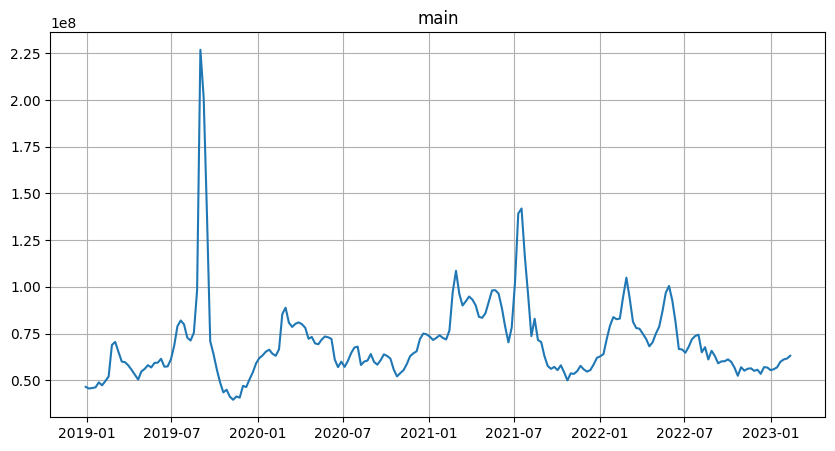

In [12]:
ts.plot();

In [30]:
HORIZON = 100
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

## naive forecast

In [31]:
from etna.models import NaiveModel
from etna.pipeline import Pipeline

# Define a model
model = NaiveModel(lag=12)

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

In [32]:
# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [33]:
from etna.metrics import MAPE

smape = MAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 28.700933095898513}

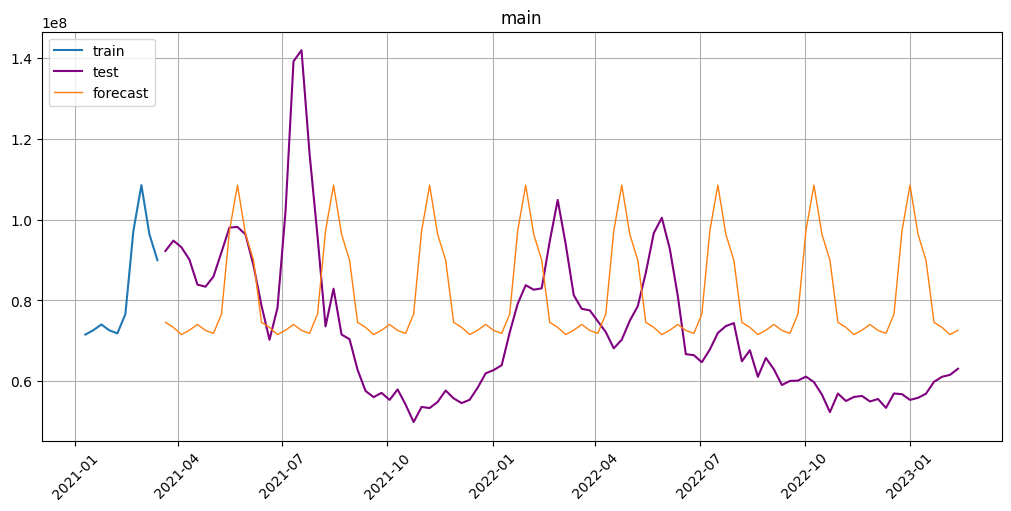

In [34]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

## Catboost

In [43]:
regressor_df

,Пеиод__неделя,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли","1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки",2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,5_выписки врачами_Выписки,6_статистика заболеваемости_Статистика заболеваемости,7_индекс цены_Индекс цены,8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),8_развитие дженериков_Развитие Дженериков \n(кол-во брендов),"11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли",...,"13_Медиа (Конкурент 11)_Диджитал, руб.10",13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, рубли.11","13_Медиа (Конкурент 12)_Диджитал, руб.11","13_Медиа (Конкурент 12)_ТВ Рег, рубли.5",13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12,timestamp
0,1,4.153557e+07,114621.15,0.92107,99698.595433,508956.0,1.541320,NaN,NaN,1057612.50,...,227587.5,5.897845e+06,191.587053,9.8385,1645238.9337096778,3.033352e+06,7.155664e+06,1.183425e+07,9.085528e+06,2018-12-31
1,2,5.122229e+07,141523.20,0.92107,99698.595433,804825.0,1.541320,NaN,NaN,844452.00,...,229446.0,6.844746e+06,142.215997,10.0800,1919445.4226612907,3.728812e+06,8.348274e+06,1.399653e+07,1.059978e+07,2019-01-07
2,3,5.712735e+07,157926.30,0.92107,99698.595433,993384.0,1.541320,NaN,NaN,1235682.00,...,984564.0,7.599864e+06,98.844036,6.1320,1919445.4226612907,1.198575e+06,8.348274e+06,1.146629e+07,1.059978e+07,2019-01-14
3,4,6.304099e+07,173746.65,0.92107,99698.595433,1186542.0,1.541320,NaN,NaN,538272.00,...,897813.0,7.513113e+06,201.975398,15.8550,1919445.4226612907,4.969125e+05,8.348274e+06,1.076463e+07,1.059978e+07,2019-01-21
4,5,6.733689e+07,185551.80,0.92107,99698.595433,1454817.0,1.541320,NaN,NaN,NaN,...,1003590.0,1.059384e+07,105.756137,6.1530,1911792.1603064518,5.961375e+05,8.477038e+06,1.098497e+07,1.289309e+07,2019-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,31,5.693151e+07,110088.30,0.99750,64408.584220,367920.0,1.542399,0.063335,15.75,3278646.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-31
240,32,5.988151e+07,115345.65,0.99750,64408.584220,390915.0,1.566483,0.070484,15.75,2701755.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-07
241,33,6.111218e+07,117761.70,0.99750,64408.584220,398580.0,1.566483,0.070484,15.75,408240.00,...,13765.5,1.376550e+04,NaN,NaN,NaN,6.939450e+04,NaN,6.939450e+04,NaN,2023-08-14
242,34,6.159493e+07,118356.00,0.99750,64408.584220,429240.0,1.566483,0.070484,15.75,309723.75,...,3591.0,3.591000e+03,NaN,NaN,NaN,7.852950e+04,NaN,7.852950e+04,NaN,2023-08-21


In [47]:
X = regressor_df.iloc[:target_df.shape[0]].copy()
y = target_df[TARGET].copy()

In [55]:
def train_regressor_model(X, y, n_splits, cat_features, model):
    
    X_train, X_test = X.iloc[:int(X.shape[0] * 0.6)], X.iloc[int(X.shape[0] * 0.6):]
    y_train, y_test = y.iloc[:int(X.shape[0] * 0.6)], y.iloc[int(X.shape[0] * 0.6):]
    
    clf = model.copy()

    # clfs.append(clf)

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    score = mean_absolute_percentage_error(y_test, y_pred)  # np.mean(np.array(y_pred == y_test))
    
    print(f"fold: MAPE score: {score}")
    return [clf]

In [68]:
model = CatBoostRegressor(
            depth=10,
            iterations=3500,
            learning_rate=0.06,
            loss_function='MAPE', 
            eval_metric="MAPE", 
            custom_metric="MAPE",
            boosting_type="Ordered",
            
            # Главная фишка катбуста - работа с категориальными признаками
            cat_features=[],
            # ignored_features = ignored_features,
            
            # Регуляризация и ускорение
            colsample_bylevel=0.098,
            subsample=0.95,
            l2_leaf_reg=9,
            min_data_in_leaf=243,
            max_bin=187,
            random_strength=1,
            
            # Параметры ускорения
            task_type="CPU",    
            thread_count=-1,
            bootstrap_type="Bernoulli", 
            
            # Важное!
            random_seed=7575,
            # auto_class_weights="SqrtBalanced",
            early_stopping_rounds=50)

In [69]:
clfs = train_regressor_model(X, y, 5, [], model)

0:	learn: 0.1854747	test: 0.1526490	best: 0.1526490 (0)	total: 1.14ms	remaining: 3.98s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1365903651
bestIteration = 14

Shrink model to first 15 iterations.
fold: MAPE score: 0.13659036471071068


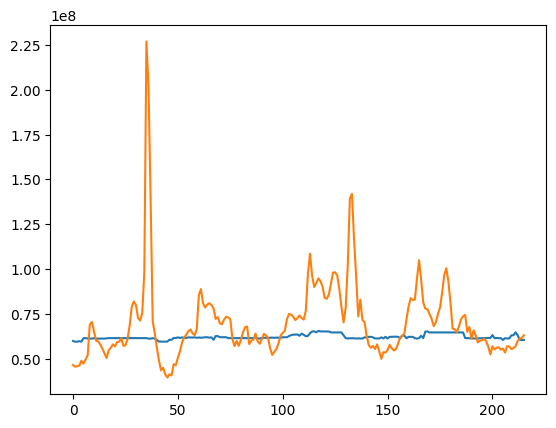

In [65]:
plt.plot(clfs[0].predict(X))
plt.plot(y)